<a href="https://colab.research.google.com/github/kazars24/educational-python-projects/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Modern_ML_Lab_1_Image_Classification_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/images.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pic = plt.imread('train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [ ]:
pic = np.transpose(pic, axes=(1, 0, 2))

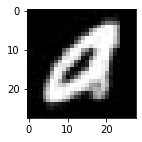

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

####Часть 1

Для начала простоим модели с 2-мя и 3-мя полносвязными слоями, batch_size=2 и оптимайзером SGD с параметрами lr=0.0001, momentum=0.9

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

train_data = torchvision.datasets.ImageFolder(root='train', transform=transform)
test_data = torchvision.datasets.ImageFolder(root = 'test', transform=transform)

Train часть разделим на *train* и *valid*, так как test уже имеется.

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

image_train_range = list(range(len(train_data.imgs)))

train, valid = train_test_split(image_train_range, test_size=.2)

In [ ]:
len(train), len(valid)

(52000, 13000)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=2, num_workers=2,
                                           sampler=SubsetRandomSampler(train))
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=2, num_workers=2,
                                           sampler=SubsetRandomSampler(valid))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=2,
                                          shuffle=True, num_workers=2)

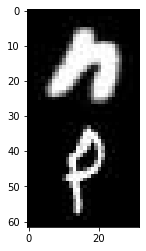

    n     p


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (2, 1, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % train_data.classes[labels[j]] for j in range(2)))

In [ ]:
len(train_data.classes)

26

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net_2(nn.Module):
  def __init__(self):
        super(Net_2, self).__init__()#28*28
        self.fc1 = nn.Linear(3 *28 * 28, 56)
        self.fc2 = nn.Linear(56, 26)

  def forward(self, x):
        x = x.view(-1, 3 *28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_2 = Net_2()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()# for classification
optimizer = optim.SGD(net_2.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_2(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 3.207
[1,  1000] loss: 3.091
[1,  1500] loss: 2.982
[1,  2000] loss: 2.845
[1,  2500] loss: 2.682
[1,  3000] loss: 2.514
[1,  3500] loss: 2.411
[1,  4000] loss: 2.204
[1,  4500] loss: 2.082
[1,  5000] loss: 1.956
[1,  5500] loss: 1.926
[1,  6000] loss: 1.796
[1,  6500] loss: 1.767
[1,  7000] loss: 1.700
[1,  7500] loss: 1.636
[1,  8000] loss: 1.658
[1,  8500] loss: 1.558
[1,  9000] loss: 1.519
[1,  9500] loss: 1.478
[1, 10000] loss: 1.516
[1, 10500] loss: 1.415
[1, 11000] loss: 1.462
[1, 11500] loss: 1.433
[1, 12000] loss: 1.426
[1, 12500] loss: 1.407
[1, 13000] loss: 1.382
[1, 13500] loss: 1.308
[1, 14000] loss: 1.261
[1, 14500] loss: 1.289
[1, 15000] loss: 1.362
[1, 15500] loss: 1.290
[1, 16000] loss: 1.223
[1, 16500] loss: 1.297
[1, 17000] loss: 1.272
[1, 17500] loss: 1.217
[1, 18000] loss: 1.345
[1, 18500] loss: 1.215
[1, 19000] loss: 1.246
[1, 19500] loss: 1.199
[1, 20000] loss: 1.256
[1, 20500] loss: 1.199
[1, 21000] loss: 1.260
[1, 21500] loss: 1.212
[1, 22000] 

In [ ]:
#PATH = './1_net_2.pth'
#torch.save(net_2.state_dict(), PATH)

In [ ]:
def valid_accuracy(model):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in valid_loader:
      images, labels = data
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the valid images: %d %%' % (
    100 * correct / total))

def test_accuracy(model):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


In [ ]:
valid_accuracy(net_2)
test_accuracy(net_2)

Accuracy of the network on the valid images: 76 %
Accuracy of the network on the test images: 76 %


Теперь то же самое для модели с 3-мя слоями

In [ ]:
class Net_3(nn.Module):
  def __init__(self):
        super(Net_3, self).__init__()#28*28
        self.fc1 = nn.Linear(3 *28 * 28, 56)
        self.fc2 = nn.Linear(56, 40)
        self.fc3 = nn.Linear(40, 26)

  def forward(self, x):
        x = x.view(-1, 3 *28 * 28)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        return x

net_3 = Net_3()

In [ ]:
optimizer = optim.SGD(net_3.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_3(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 3.247
[1,  1000] loss: 3.207
[1,  1500] loss: 3.158
[1,  2000] loss: 3.114
[1,  2500] loss: 3.052
[1,  3000] loss: 2.988
[1,  3500] loss: 2.931
[1,  4000] loss: 2.820
[1,  4500] loss: 2.728
[1,  5000] loss: 2.612
[1,  5500] loss: 2.475
[1,  6000] loss: 2.407
[1,  6500] loss: 2.322
[1,  7000] loss: 2.224
[1,  7500] loss: 2.155
[1,  8000] loss: 2.076
[1,  8500] loss: 2.021
[1,  9000] loss: 1.968
[1,  9500] loss: 1.939
[1, 10000] loss: 1.895
[1, 10500] loss: 1.811
[1, 11000] loss: 1.756
[1, 11500] loss: 1.796
[1, 12000] loss: 1.634
[1, 12500] loss: 1.630
[1, 13000] loss: 1.607
[1, 13500] loss: 1.609
[1, 14000] loss: 1.501
[1, 14500] loss: 1.570
[1, 15000] loss: 1.605
[1, 15500] loss: 1.573
[1, 16000] loss: 1.473
[1, 16500] loss: 1.470
[1, 17000] loss: 1.586
[1, 17500] loss: 1.441
[1, 18000] loss: 1.544
[1, 18500] loss: 1.472
[1, 19000] loss: 1.495
[1, 19500] loss: 1.431
[1, 20000] loss: 1.356
[1, 20500] loss: 1.398
[1, 21000] loss: 1.415
[1, 21500] loss: 1.478
[1, 22000] 

In [ ]:
#PATH = './1_net_3.pth'
#torch.save(net_3.state_dict(), PATH)

In [ ]:
valid_accuracy(net_3)
test_accuracy(net_3)

Accuracy of the network on the valid images: 68 %
Accuracy of the network on the test images: 68 %


Модель с 2-мя слоями справилась лучше, поэтому на ее основе будем пробовать различные параметры нейронной сети.

Например, добавим нормализацию, изменим кол-во нейронов на слоях, добавим функцию активации, попробуем разные оптимайзеры и тд.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root='train', transform=transform)
test_data = torchvision.datasets.ImageFolder(root = 'test', transform=transform)

image_train_range = list(range(len(train_data.imgs)))
train, valid = train_test_split(image_train_range, test_size=.2)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, num_workers=2,
                                           sampler=SubsetRandomSampler(train))
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=4, num_workers=2,
                                           sampler=SubsetRandomSampler(valid))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                          shuffle=True, num_workers=2)

In [ ]:
class Net_4(nn.Module):
  def __init__(self):
        super(Net_4, self).__init__()#28*28
        self.fc1 = nn.Linear(3 * 28 * 28, 64)
        self.fc2 = nn.Linear(64, 26)

  def forward(self, x):
        x = x.view(-1, 3 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_4 = Net_4()

In [ ]:
optimizer = optim.Adam(net_4.parameters(), lr=0.0001)

In [ ]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_4(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 2.713
[1,  1000] loss: 1.997
[1,  1500] loss: 1.726
[1,  2000] loss: 1.552
[1,  2500] loss: 1.436
[1,  3000] loss: 1.415
[1,  3500] loss: 1.301
[1,  4000] loss: 1.316
[1,  4500] loss: 1.292
[1,  5000] loss: 1.296
[1,  5500] loss: 1.250
[1,  6000] loss: 1.249
[1,  6500] loss: 1.184
[1,  7000] loss: 1.184
[1,  7500] loss: 1.106
[1,  8000] loss: 1.181
[1,  8500] loss: 1.137
[1,  9000] loss: 1.079
[1,  9500] loss: 1.074
[1, 10000] loss: 1.056
[1, 10500] loss: 1.155
[1, 11000] loss: 1.082
[1, 11500] loss: 1.118
[1, 12000] loss: 1.083
[1, 12500] loss: 1.057
[1, 13000] loss: 1.065
[2,   500] loss: 1.026
[2,  1000] loss: 1.051
[2,  1500] loss: 1.044
[2,  2000] loss: 0.938
[2,  2500] loss: 0.988
[2,  3000] loss: 0.929
[2,  3500] loss: 0.979
[2,  4000] loss: 1.020
[2,  4500] loss: 0.982
[2,  5000] loss: 0.947
[2,  5500] loss: 0.956
[2,  6000] loss: 0.951
[2,  6500] loss: 0.942
[2,  7000] loss: 0.909
[2,  7500] loss: 0.947
[2,  8000] loss: 0.972
[2,  8500] loss: 0.911
[2,  9000] 

In [ ]:
valid_accuracy(net_4)
test_accuracy(net_4)

Accuracy of the network on the valid images: 77 %
Accuracy of the network on the test images: 76 %


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, num_workers=2,
                                           sampler=SubsetRandomSampler(train))
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=8, num_workers=2,
                                           sampler=SubsetRandomSampler(valid))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8,
                                          shuffle=True, num_workers=2)

In [ ]:
class Net_5(nn.Module):
  def __init__(self):
        super(Net_5, self).__init__()#28*28
        self.fc1 = nn.Linear(3 * 28 * 28, 52)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(52, 26)

  def forward(self, x):
        x = x.view(-1, 3 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net_5 = Net_5()

In [ ]:
optimizer = optim.SGD(net_5.parameters(), lr=0.0002, momentum=0.95)

In [ ]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_5(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 2.795
[1,  1000] loss: 1.979
[1,  1500] loss: 1.683
[1,  2000] loss: 1.497
[1,  2500] loss: 1.377
[1,  3000] loss: 1.383
[1,  3500] loss: 1.340
[1,  4000] loss: 1.326
[1,  4500] loss: 1.227
[1,  5000] loss: 1.259
[1,  5500] loss: 1.190
[1,  6000] loss: 1.161
[1,  6500] loss: 1.157
[2,   500] loss: 1.111
[2,  1000] loss: 1.104
[2,  1500] loss: 1.071
[2,  2000] loss: 1.096
[2,  2500] loss: 1.047
[2,  3000] loss: 1.023
[2,  3500] loss: 1.021
[2,  4000] loss: 0.959
[2,  4500] loss: 1.024
[2,  5000] loss: 1.004
[2,  5500] loss: 0.989
[2,  6000] loss: 0.968
[2,  6500] loss: 0.958
[3,   500] loss: 0.938
[3,  1000] loss: 0.929
[3,  1500] loss: 0.890
[3,  2000] loss: 0.942
[3,  2500] loss: 0.874
[3,  3000] loss: 0.910
[3,  3500] loss: 0.919
[3,  4000] loss: 0.880
[3,  4500] loss: 0.882
[3,  5000] loss: 0.877
[3,  5500] loss: 0.849
[3,  6000] loss: 0.882
[3,  6500] loss: 0.883
Finished Training


In [ ]:
#PATH = './1_net_5.pth'
#torch.save(net_5.state_dict(), PATH)

In [ ]:
valid_accuracy(net_5)
test_accuracy(net_5)

Accuracy of the network on the valid images: 74 %
Accuracy of the network on the test images: 73 %


Net_4 справилась лучше всех с точностью 77% и 78% на валидационной и тестовой выборках соответственно

####Часть 2

In [ ]:
size = len(test_loader.dataset)
correct = 0
total = 0
prediction = []
ground_truth = []
with torch.no_grad():
  for images, labels in test_loader:
    outputs = net_4(images)
    _, predicted = torch.max(outputs, 1)
    prediction.extend(predicted)
    ground_truth.extend(labels)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
pred = list(map(lambda x : test_data.classes[x], prediction))
gt = list(map(lambda x : test_data.classes[x], ground_truth))

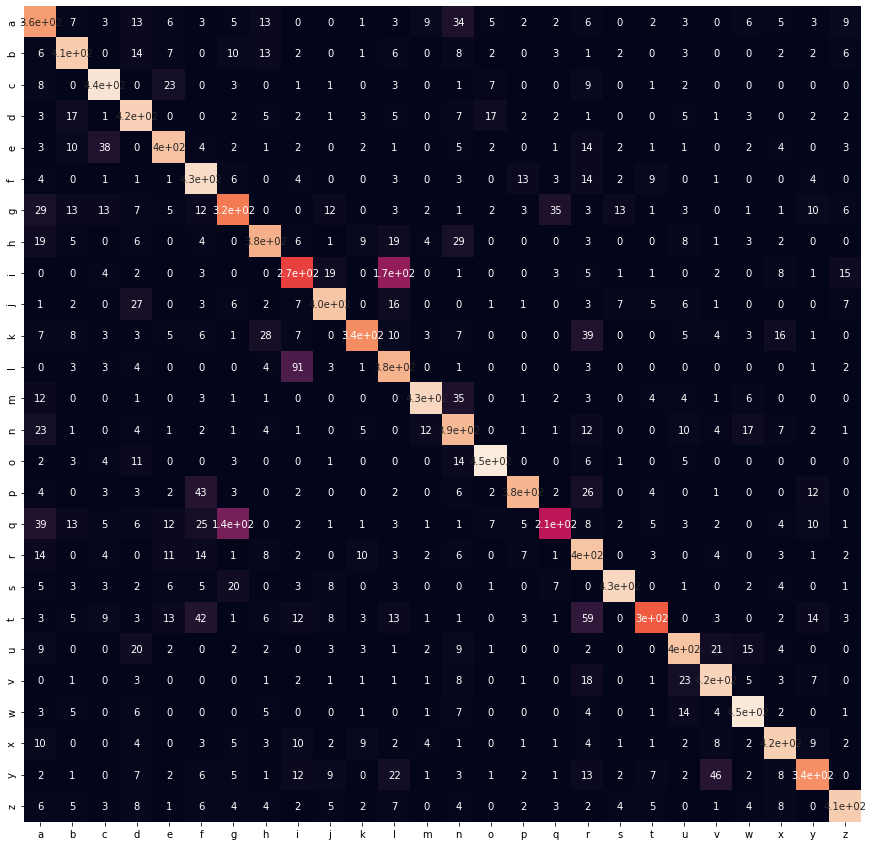

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(gt, pred)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, cbar=False, xticklabels=test_data.classes, yticklabels=test_data.classes)

<BarContainer object of 26 artists>

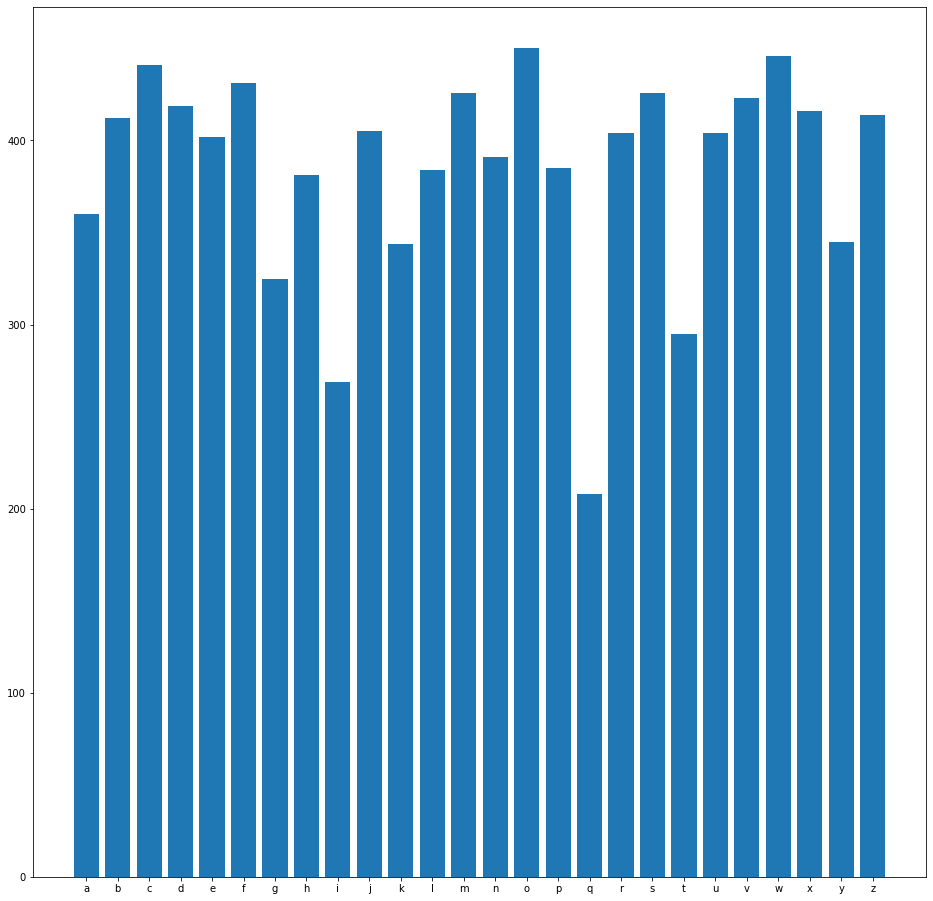

In [ ]:
plt.figure(figsize=(16, 16))
letters = [cm[i][i] for i in range(26)]
plt.bar(test_data.classes, letters)

В целом, модель обучилась  не очень равномерно, есть несколько букв, которые часто путаются между собой. Далее найдем эти буквы.

In [ ]:
len(test_loader.dataset) / 26

500.0

In [ ]:
letter_size = len(test_loader.dataset) / 26
best = test_data.classes[letters.index(max(letters))]
worst = test_data.classes[letters.index(min(letters))]
best_accurracy = max(letters) / letter_size
worst_accurracy = min(letters) / letter_size
print('The best recognized letter is', best, 'with accuracy =', best_accurracy)
print('The worst recognized letter is', worst, 'with accuracy =', worst_accurracy)

The best recognized letter is o with accuracy = 0.9
The worst recognized letter is q with accuracy = 0.416


####Часть 3

In [ ]:
confusions = []
for i in range(26):
  for j in range(26):
    if i != j:
      confusions.append((cm[i][j], test_data.classes[i], test_data.classes[j]))

confusions = sorted(confusions, reverse=True)[0:11]
for id, (num, true, false) in enumerate(confusions):
  print(f'"{true}" was recognized as "{false}" {num} times')


"i" was recognized as "l" 166 times
"q" was recognized as "g" 136 times
"l" was recognized as "i" 91 times
"t" was recognized as "r" 59 times
"y" was recognized as "v" 46 times
"p" was recognized as "f" 43 times
"t" was recognized as "f" 42 times
"q" was recognized as "a" 39 times
"k" was recognized as "r" 39 times
"e" was recognized as "c" 38 times
"m" was recognized as "n" 35 times


Эти пары букв чаще всего путались между собой, так как имеют схожую форму.

Например:

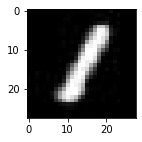

In [ ]:
i = plt.imread('train/i/i_00024.jpg')
i = np.transpose(i, axes=(1, 0, 2))
plt.figure(figsize=(2,2))
plt.imshow(i)
plt.show()

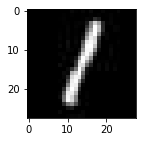

In [ ]:
l = plt.imread('train/l/l_00083.jpg')
l = np.transpose(l, axes=(1, 0, 2))
plt.figure(figsize=(2,2))
plt.imshow(l)
plt.show()

Буквы i и l выглядят практически идентично.

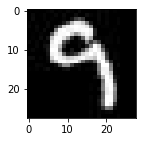

In [ ]:
q = plt.imread('train/q/q_00532.jpg')
q = np.transpose(q, axes=(1, 0, 2))
plt.figure(figsize=(2,2))
plt.imshow(q)
plt.show()

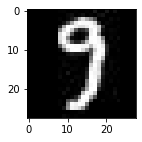

In [ ]:
g = plt.imread('train/g/g_00218.jpg')
g = np.transpose(g, axes=(1, 0, 2))
plt.figure(figsize=(2,2))
plt.imshow(g)
plt.show()

Аналогично и с другими парами букв.

####Часть 4

Первая буква моей фамилии - это "к"

In [ ]:
id_k = test_data.classes.index('k')
accuracy_k = cm[id_k][id_k] / letter_size
print('Accuracy of "k" is', accuracy_k)

Accuracy of "k" is 0.688


In [ ]:
confusions_k = []
for j in range(26):
    if j != id_k:
      confusions_k.append((cm[id_k][j], test_data.classes[id_k], test_data.classes[j]))

confusions_k = sorted(confusions_k, reverse=True)[0:5]
for id, (num, true, false) in enumerate(confusions_k):
  print(f'"{true}" was recognized as "{false}" {num} times')

"k" was recognized as "r" 39 times
"k" was recognized as "h" 28 times
"k" was recognized as "x" 16 times
"k" was recognized as "l" 10 times
"k" was recognized as "b" 8 times


### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

####Часть 1

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root='train', transform=transform)
test_data = torchvision.datasets.ImageFolder(root = 'test', transform=transform)

image_train_range = list(range(len(train_data.imgs)))
train, valid = train_test_split(image_train_range, test_size=.2)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, num_workers=2,
                                           sampler=SubsetRandomSampler(train))
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=4, num_workers=2,
                                           sampler=SubsetRandomSampler(valid))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                          shuffle=True, num_workers=2)

Нейронная сеть с 1 сверточным слоем:

In [ ]:
class Net_1conv(nn.Module):
  def __init__(self):
        super(Net_1conv, self).__init__()#28*28
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.fc1 = nn.Linear(8 * 26 * 26, 128)
        self.fc2 = nn.Linear(128, 26)

  def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 8 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_1conv = Net_1conv()

In [ ]:
optimizer = optim.SGD(net_1conv.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_1conv(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 2.900
[1,  1000] loss: 1.920
[1,  1500] loss: 1.541
[1,  2000] loss: 1.390
[1,  2500] loss: 1.235
[1,  3000] loss: 1.275
[1,  3500] loss: 1.233
[1,  4000] loss: 1.160
[1,  4500] loss: 1.094
[1,  5000] loss: 1.131
[1,  5500] loss: 1.063
[1,  6000] loss: 0.993
[1,  6500] loss: 0.973
[1,  7000] loss: 0.956
[1,  7500] loss: 0.860
[1,  8000] loss: 0.910
[1,  8500] loss: 0.867
[1,  9000] loss: 0.846
[1,  9500] loss: 0.792
[1, 10000] loss: 0.816
[1, 10500] loss: 0.796
[1, 11000] loss: 0.838
[1, 11500] loss: 0.745
[1, 12000] loss: 0.793
[1, 12500] loss: 0.769
[1, 13000] loss: 0.693
[2,   500] loss: 0.650
[2,  1000] loss: 0.723
[2,  1500] loss: 0.678
[2,  2000] loss: 0.659
[2,  2500] loss: 0.670
[2,  3000] loss: 0.689
[2,  3500] loss: 0.645
[2,  4000] loss: 0.607
[2,  4500] loss: 0.667
[2,  5000] loss: 0.614
[2,  5500] loss: 0.626
[2,  6000] loss: 0.642
[2,  6500] loss: 0.626
[2,  7000] loss: 0.634
[2,  7500] loss: 0.610
[2,  8000] loss: 0.634
[2,  8500] loss: 0.628
[2,  9000] 

In [ ]:
valid_accuracy(net_1conv)
test_accuracy(net_1conv)

Accuracy of the network on the valid images: 85 %
Accuracy of the network on the test images: 85 %


Нейронная сеть с 2 сверточными слоями:

In [ ]:
class Net_2conv(nn.Module):
  def __init__(self):
        super(Net_2conv, self).__init__()#28*28
        self.conv1 = nn.Conv2d(3, 8, 3) #26*26
        self.conv2 = nn.Conv2d(8, 16, 3) #24*24
        self.fc1 = nn.Linear(16 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 26)

  def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 16 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_2conv = Net_2conv()

In [ ]:
optimizer = optim.SGD(net_2conv.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_2conv(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 3.075
[1,  1000] loss: 1.881
[1,  1500] loss: 1.524
[1,  2000] loss: 1.289
[1,  2500] loss: 1.205
[1,  3000] loss: 1.154
[1,  3500] loss: 1.142
[1,  4000] loss: 1.039
[1,  4500] loss: 1.002
[1,  5000] loss: 1.002
[1,  5500] loss: 0.919
[1,  6000] loss: 0.877
[1,  6500] loss: 0.860
[1,  7000] loss: 0.829
[1,  7500] loss: 0.870
[1,  8000] loss: 0.786
[1,  8500] loss: 0.748
[1,  9000] loss: 0.717
[1,  9500] loss: 0.713
[1, 10000] loss: 0.796
[1, 10500] loss: 0.685
[1, 11000] loss: 0.679
[1, 11500] loss: 0.707
[1, 12000] loss: 0.695
[1, 12500] loss: 0.722
[1, 13000] loss: 0.628
[2,   500] loss: 0.575
[2,  1000] loss: 0.620
[2,  1500] loss: 0.588
[2,  2000] loss: 0.593
[2,  2500] loss: 0.583
[2,  3000] loss: 0.557
[2,  3500] loss: 0.600
[2,  4000] loss: 0.564
[2,  4500] loss: 0.585
[2,  5000] loss: 0.600
[2,  5500] loss: 0.524
[2,  6000] loss: 0.557
[2,  6500] loss: 0.496
[2,  7000] loss: 0.562
[2,  7500] loss: 0.527
[2,  8000] loss: 0.516
[2,  8500] loss: 0.510
[2,  9000] 

In [ ]:
valid_accuracy(net_2conv)
test_accuracy(net_2conv)

Accuracy of the network on the valid images: 86 %
Accuracy of the network on the test images: 86 %



Нейронная сеть с 3 сверточными слоями:

In [ ]:
class Net_3conv(nn.Module):
  def __init__(self):
        super(Net_3conv, self).__init__()#28*28
        self.conv1 = nn.Conv2d(3, 6, 3) #26*26
        self.conv2 = nn.Conv2d(6, 16, 3) #24*24
        self.conv3 = nn.Conv2d(16, 32, 2) #23*23
        self.fc1 = nn.Linear(32 * 23 * 23, 128)
        self.fc2 = nn.Linear(128, 26)

  def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 32 * 23 * 23)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_3conv = Net_3conv()

In [ ]:
optimizer = optim.SGD(net_3conv.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_3conv(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 3.100
[1,  1000] loss: 1.884
[1,  1500] loss: 1.437
[1,  2000] loss: 1.268
[1,  2500] loss: 1.241
[1,  3000] loss: 1.169
[1,  3500] loss: 1.087
[1,  4000] loss: 1.028
[1,  4500] loss: 0.935
[1,  5000] loss: 0.932
[1,  5500] loss: 0.940
[1,  6000] loss: 0.915
[1,  6500] loss: 0.819
[1,  7000] loss: 0.786
[1,  7500] loss: 0.766
[1,  8000] loss: 0.813
[1,  8500] loss: 0.730
[1,  9000] loss: 0.712
[1,  9500] loss: 0.718
[1, 10000] loss: 0.651
[1, 10500] loss: 0.666
[1, 11000] loss: 0.680
[1, 11500] loss: 0.695
[1, 12000] loss: 0.661
[1, 12500] loss: 0.707
[1, 13000] loss: 0.655
[2,   500] loss: 0.586
[2,  1000] loss: 0.626
[2,  1500] loss: 0.595
[2,  2000] loss: 0.574
[2,  2500] loss: 0.560
[2,  3000] loss: 0.551
[2,  3500] loss: 0.600
[2,  4000] loss: 0.528
[2,  4500] loss: 0.617
[2,  5000] loss: 0.577
[2,  5500] loss: 0.520
[2,  6000] loss: 0.519
[2,  6500] loss: 0.529
[2,  7000] loss: 0.540
[2,  7500] loss: 0.550
[2,  8000] loss: 0.516
[2,  8500] loss: 0.539
[2,  9000] 

In [ ]:
valid_accuracy(net_3conv)
test_accuracy(net_3conv)

Accuracy of the network on the valid images: 86 %
Accuracy of the network on the test images: 86 %


Теперь попробуем различные параметры.

In [ ]:
class Net_3conv_2(nn.Module):
  def __init__(self):
        super(Net_3conv_2, self).__init__()#28*28
        self.conv1 = nn.Conv2d(3, 9, 5) #24*24
        self.conv2 = nn.Conv2d(9, 18, 3) #22*22
        self.conv3 = nn.Conv2d(18, 36, 2, 2) #11*11
        self.fc1 = nn.Linear(36 * 11 * 11, 128)
        self.fc2 = nn.Linear(128, 26)

  def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 36 * 11 * 11)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_3conv_2 = Net_3conv_2()

In [ ]:
#optimizer = optim.SGD(net_3conv_2.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(net_3conv_2.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_3conv_2(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 1.775
[1,  1000] loss: 1.218
[1,  1500] loss: 1.094
[1,  2000] loss: 0.979
[1,  2500] loss: 0.914
[1,  3000] loss: 0.885
[1,  3500] loss: 0.742
[1,  4000] loss: 0.787
[1,  4500] loss: 0.745
[1,  5000] loss: 0.764
[1,  5500] loss: 0.697
[1,  6000] loss: 0.684
[1,  6500] loss: 0.698
[1,  7000] loss: 0.701
[1,  7500] loss: 0.700
[1,  8000] loss: 0.663
[1,  8500] loss: 0.647
[1,  9000] loss: 0.606
[1,  9500] loss: 0.626
[1, 10000] loss: 0.602
[1, 10500] loss: 0.607
[1, 11000] loss: 0.615
[1, 11500] loss: 0.590
[1, 12000] loss: 0.614
[1, 12500] loss: 0.643
[1, 13000] loss: 0.567
[2,   500] loss: 0.515
[2,  1000] loss: 0.487
[2,  1500] loss: 0.519
[2,  2000] loss: 0.553
[2,  2500] loss: 0.529
[2,  3000] loss: 0.538
[2,  3500] loss: 0.546
[2,  4000] loss: 0.585
[2,  4500] loss: 0.521
[2,  5000] loss: 0.530
[2,  5500] loss: 0.501
[2,  6000] loss: 0.511
[2,  6500] loss: 0.547
[2,  7000] loss: 0.479
[2,  7500] loss: 0.521
[2,  8000] loss: 0.483
[2,  8500] loss: 0.531
[2,  9000] 

In [ ]:
valid_accuracy(net_3conv_2)
test_accuracy(net_3conv_2)

Accuracy of the network on the valid images: 85 %
Accuracy of the network on the test images: 85 %


In [ ]:
class Net_3conv_3(nn.Module):
  def __init__(self):
        super(Net_3conv_3, self).__init__()#28*28
        self.conv1 = nn.Conv2d(3, 32, 4, 2) #13*13
        self.conv2 = nn.Conv2d(32, 64, 3) #11*11
        self.conv3 = nn.Conv2d(64, 128, 3) #9*9
        self.fc1 = nn.Linear(128 * 9 * 9, 128)
        self.fc2 = nn.Linear(128, 26)

  def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 128 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_3conv_3 = Net_3conv_3()

In [ ]:
optimizer = optim.SGD(net_3conv_3.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_3conv_3(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 3.159
[1,  1000] loss: 2.309
[1,  1500] loss: 1.602
[1,  2000] loss: 1.399
[1,  2500] loss: 1.317
[1,  3000] loss: 1.204
[1,  3500] loss: 1.167
[1,  4000] loss: 1.039
[1,  4500] loss: 1.001
[1,  5000] loss: 0.981
[1,  5500] loss: 0.909
[1,  6000] loss: 0.887
[1,  6500] loss: 0.856
[1,  7000] loss: 0.859
[1,  7500] loss: 0.845
[1,  8000] loss: 0.812
[1,  8500] loss: 0.772
[1,  9000] loss: 0.769
[1,  9500] loss: 0.749
[1, 10000] loss: 0.685
[1, 10500] loss: 0.703
[1, 11000] loss: 0.703
[1, 11500] loss: 0.713
[1, 12000] loss: 0.726
[1, 12500] loss: 0.702
[1, 13000] loss: 0.653
[2,   500] loss: 0.575
[2,  1000] loss: 0.673
[2,  1500] loss: 0.653
[2,  2000] loss: 0.620
[2,  2500] loss: 0.569
[2,  3000] loss: 0.583
[2,  3500] loss: 0.601
[2,  4000] loss: 0.562
[2,  4500] loss: 0.553
[2,  5000] loss: 0.581
[2,  5500] loss: 0.592
[2,  6000] loss: 0.548
[2,  6500] loss: 0.611
[2,  7000] loss: 0.615
[2,  7500] loss: 0.527
[2,  8000] loss: 0.569
[2,  8500] loss: 0.593
[2,  9000] 

In [ ]:
valid_accuracy(net_3conv_3)
test_accuracy(net_3conv_3)

Accuracy of the network on the valid images: 86 %
Accuracy of the network on the test images: 86 %


Лучшее всего справились модели *net_3conv* и *net_3conv_3* с точностью 86%

####Часть 2

Далее посмотрим как изменится точность сети *net_3conv*, если добавить BatchNorm и GroupNorm

In [ ]:
class Net_bn(nn.Module):
  def __init__(self):
        super(Net_bn, self).__init__()#28*28
        self.conv1 = nn.Conv2d(3, 6, 3) #26*26
        self.batch1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3) #24*24
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 2) #23*23
        self.fc1 = nn.Linear(32 * 23 * 23, 128)
        self.fc2 = nn.Linear(128, 26)

  def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = x.view(-1, 32 * 23 * 23)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_bn = Net_bn()

In [ ]:
optimizer = optim.SGD(net_bn.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_bn(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 2.410
[1,  1000] loss: 1.389
[1,  1500] loss: 1.159
[1,  2000] loss: 1.131
[1,  2500] loss: 1.007
[1,  3000] loss: 0.949
[1,  3500] loss: 0.970
[1,  4000] loss: 0.895
[1,  4500] loss: 0.847
[1,  5000] loss: 0.831
[1,  5500] loss: 0.777
[1,  6000] loss: 0.785
[1,  6500] loss: 0.768
[1,  7000] loss: 0.721
[1,  7500] loss: 0.700
[1,  8000] loss: 0.678
[1,  8500] loss: 0.707
[1,  9000] loss: 0.673
[1,  9500] loss: 0.659
[1, 10000] loss: 0.656
[1, 10500] loss: 0.641
[1, 11000] loss: 0.563
[1, 11500] loss: 0.614
[1, 12000] loss: 0.617
[1, 12500] loss: 0.589
[1, 13000] loss: 0.560
[2,   500] loss: 0.561
[2,  1000] loss: 0.509
[2,  1500] loss: 0.521
[2,  2000] loss: 0.556
[2,  2500] loss: 0.476
[2,  3000] loss: 0.547
[2,  3500] loss: 0.537
[2,  4000] loss: 0.529
[2,  4500] loss: 0.474
[2,  5000] loss: 0.500
[2,  5500] loss: 0.508
[2,  6000] loss: 0.501
[2,  6500] loss: 0.508
[2,  7000] loss: 0.517
[2,  7500] loss: 0.502
[2,  8000] loss: 0.487
[2,  8500] loss: 0.482
[2,  9000] 

In [ ]:
valid_accuracy(net_bn)
test_accuracy(net_bn)

Accuracy of the network on the valid images: 87 %
Accuracy of the network on the test images: 87 %


Добавив BatchNorm, точность модели увеличилась до 87%

Теперь попробуем использовать GroupNorm

In [ ]:
class Net_gn(nn.Module):
  def __init__(self):
        super(Net_gn, self).__init__()#28*28
        self.conv1 = nn.Conv2d(3, 6, 3) #26*26
        self.group1 = nn.GroupNorm(3, 6)
        self.conv2 = nn.Conv2d(6, 16, 3) #24*24
        self.group2 = nn.GroupNorm(4, 16)
        self.conv3 = nn.Conv2d(16, 32, 2) #23*23
        self.fc1 = nn.Linear(32 * 23 * 23, 128)
        self.fc2 = nn.Linear(128, 26)

  def forward(self, x):
        x = self.conv1(x)
        x = self.group1(x)
        x = self.conv2(x)
        x = self.group2(x)
        x = self.conv3(x)
        x = x.view(-1, 32 * 23 * 23)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_gn = Net_gn()

In [ ]:
optimizer = optim.SGD(net_gn.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_gn(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 2.339
[1,  1000] loss: 1.467
[1,  1500] loss: 1.205
[1,  2000] loss: 1.086
[1,  2500] loss: 1.054
[1,  3000] loss: 0.976
[1,  3500] loss: 0.965
[1,  4000] loss: 0.885
[1,  4500] loss: 0.846
[1,  5000] loss: 0.850
[1,  5500] loss: 0.790
[1,  6000] loss: 0.716
[1,  6500] loss: 0.704
[1,  7000] loss: 0.689
[1,  7500] loss: 0.692
[1,  8000] loss: 0.692
[1,  8500] loss: 0.686
[1,  9000] loss: 0.601
[1,  9500] loss: 0.690
[1, 10000] loss: 0.642
[1, 10500] loss: 0.578
[1, 11000] loss: 0.590
[1, 11500] loss: 0.573
[1, 12000] loss: 0.635
[1, 12500] loss: 0.597
[1, 13000] loss: 0.578
[2,   500] loss: 0.518
[2,  1000] loss: 0.545
[2,  1500] loss: 0.512
[2,  2000] loss: 0.524
[2,  2500] loss: 0.554
[2,  3000] loss: 0.510
[2,  3500] loss: 0.442
[2,  4000] loss: 0.486
[2,  4500] loss: 0.493
[2,  5000] loss: 0.476
[2,  5500] loss: 0.495
[2,  6000] loss: 0.474
[2,  6500] loss: 0.476
[2,  7000] loss: 0.485
[2,  7500] loss: 0.457
[2,  8000] loss: 0.508
[2,  8500] loss: 0.526
[2,  9000] 

In [ ]:
valid_accuracy(net_gn)
test_accuracy(net_gn)

Accuracy of the network on the valid images: 87 %
Accuracy of the network on the test images: 87 %


С GroupNorm тоже 87%.

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=2,
                                           sampler=SubsetRandomSampler(train))
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=2,
                                           sampler=SubsetRandomSampler(valid))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=True, num_workers=2)

In [ ]:
class Net(nn.Module):
  def __init__(self):
        super(Net, self).__init__()#28*28
        self.conv1 = nn.Conv2d(3, 32, 3)#26*26
        self.pool = nn.MaxPool2d(2, 2)#13*13
        self.conv2 = nn.Conv2d(32, 64, 4)#10*10 -> 5*5
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 26)


  def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)


        return x

net = Net()

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.0007)

In [ ]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        #outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    
            # ...log the running loss
            # YOUR CODE
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.118
[2,  1000] loss: 0.115
[3,  1000] loss: 0.109
[4,  1000] loss: 0.108
[5,  1000] loss: 0.103
[6,  1000] loss: 0.099
[7,  1000] loss: 0.101
[8,  1000] loss: 0.106
[9,  1000] loss: 0.098
[10,  1000] loss: 0.095
Finished Training


In [ ]:
valid_accuracy(net)
test_accuracy(net)

Accuracy of the network on the valid images: 91 %
Accuracy of the network on the test images: 91 %


## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

In [ ]:
pic = plt.imread('/content/drive/MyDrive/task_letters/f/f.jpg')
print(pic.shape)

(28, 28, 3)


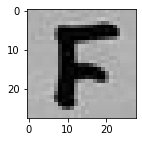

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size=(28, 28)),
     transforms.RandomInvert(p=1),
     transforms.RandomRotation(degrees=(270, 270)),
     transforms.RandomHorizontalFlip(p=1),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

task_data = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/task_letters', transform=transform)


In [ ]:
task_loader = torch.utils.data.DataLoader(task_data, batch_size=5,
                                          shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


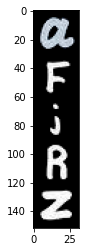

    a     f     j     r     z


In [ ]:

dataiter = iter(task_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % task_data.classes[labels[j]] for j in range(5)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in task_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the task images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the task images: 20 %


**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.